In [2]:
import pandas as pd
import glob
from datetime import datetime, timedelta
import networkx as nx

In [ ]:
import matplotlib.pyplot as plt

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("paper")

# Get files

In [5]:
files = sorted(glob.glob("data/sites/INFN_T1/*.json"))

In [6]:
len(files)

59591

In [7]:
file_iter = iter(files)

In [8]:
len(files)//11

5417

In [9]:
# traceroute = pd.concat( [pd.read_json(next(file_iter), orient='index').T for _ in range(11)],  ignore_index=True)

In [10]:
# traceroute.T.head()

In [11]:
# traceroute.head(1)

In [12]:
# traceroute["destination_reached"]

# Graph

In [13]:
def add_node(node, **kwargs):
    global g
    g: nx.Graph
    if node not in g:
        g.add_node(node, n=1, **kwargs)
    else:
        # increment the number of times we have seen this node
        g.nodes[node]["n"]+=1
        
        # add the attributes
        for k, v in kwargs.items():
            if k not in g.nodes[node]:
                g.nodes[node][k] = v

In [14]:
def add_edge(src_node, dest_node, **kwargs):
    # adds the edge in the same way as the add_node function
    if (src_node, dest_node) not in g.edges:
        g.add_edge(src_node, dest_node, n=1, **kwargs) 
    else:
        g.edges[src_node, dest_node]["n"]+=1
        for k, v in kwargs.items():
            if k not in g.edges[src_node, dest_node]:
                g.edges[src_node, dest_node][k] = v
            else:
                g.edges[src_node, dest_node][k]+= v

In [15]:
def extract_data_from_traceroute(row):

    if not row["n_hops"]:
        return

    src = row["src"]
    dest = row["dest"]
    
    if "src_site" not in row:
        row["src_site"] = "UNKNOWN"
    if "src_VO" not in row:
        row["src_VO"] = "UNKNOWN"

    add_node(src, color='red', **{x: row[f"src_{x}"] for x in ["VO", "host", "production", "site"]})
    add_node(dest, color='green', **{x: row[f"dest_{x}"] for x in ["VO", "host", "production", "site"]})

    # extract delta ttl a rtt
    ttls = row["ttls"] 
    rtts = row["rtts"]
    delta_ttls = [x - ttls[i-1] if i else x for i,x in enumerate(ttls)]
    delta_rtts = [x - rtts[i-1] if i else x for i,x in enumerate(rtts)]

    
    # for each edge, update statistics
    curr = src
    for (ip_address, delta_ttl, delta_rtt) in zip(row["hops"], delta_ttls, delta_rtts):
        # add node
        add_node(ip_address)
        add_edge(curr, ip_address, delta_ttl=delta_ttl, delta_rtt=delta_rtt)
        curr = ip_address

    # add statistics
    ts = pd.to_datetime(row["timestamp"], unit='ms')
    max_delta_ttl = max(delta_ttls) if delta_ttls else 1
    max_delta_rtt = max(delta_rtts) if delta_rtts else 1
    num_hops = row["n_hops"]
    
    stat_df.loc[ts] = [src, dest, len(g.nodes), len(g.edges), max_delta_rtt, max_delta_ttl, num_hops, row["destination_reached"]]

In [16]:
from tqdm import tqdm

In [17]:
stat_df = pd.DataFrame({"src":[], "dest":[], "num_nodes":[], "num_edges":[], "max_delta_rtts": [], "max_delta_ttls":[], "n_hops":[], "reached":[]}, index=pd.DatetimeIndex([]))
stat_df

,src,dest,num_nodes,num_edges,max_delta_rtts,max_delta_ttls,n_hops,reached


In [18]:
g = nx.Graph()

In [19]:
for file in tqdm(files[:len(files)//3]):
    # traceroute = pd.concat( [pd.read_json(next(file_iter), orient='index').T for _ in range(11)],  ignore_index=True)
    # for index, row in traceroute.iterrows():
    df = pd.read_json(file, orient='index').T
    for idx, row in df.iterrows():
        extract_data_from_traceroute(row)

100%|████████████████████████████████████| 19863/19863 [01:49<00:00, 181.28it/s]


In [21]:
# TODO: calculate average number of neighbors per node
num_neighs = list(map(lambda x: len(list(g.neighbors(x))), g.nodes))

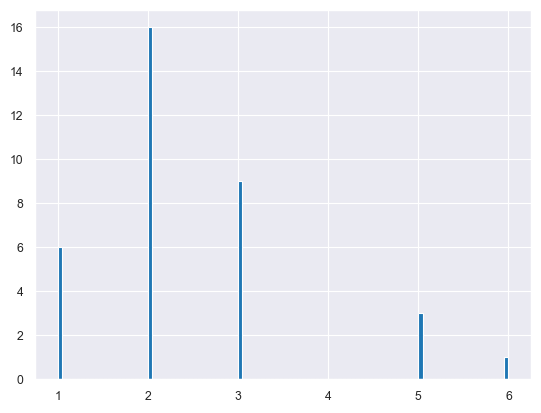

In [24]:
plt.hist(num_neighs, bins=100);

In [25]:
len(g.nodes)

35

In [26]:
len(g.edges)

43

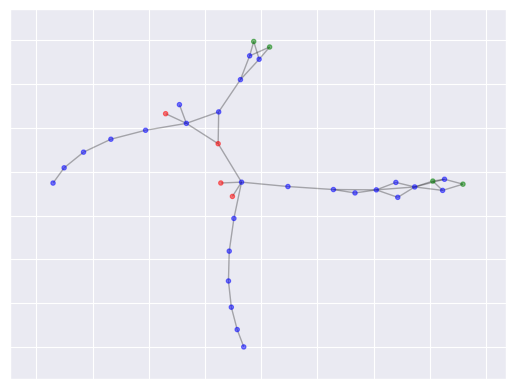

In [29]:
layout = nx.spring_layout(g)
nx.draw_networkx_edges(g, layout, alpha=0.3)
nx.draw_networkx_nodes(g.nodes, layout, node_size=10, node_color=[x.get("color", "blue") for i,x in g.nodes(data=True)], alpha=0.5)
# nx.draw_networkx(g, layout, with_labels=False) # type: ignore

<AxesSubplot: >

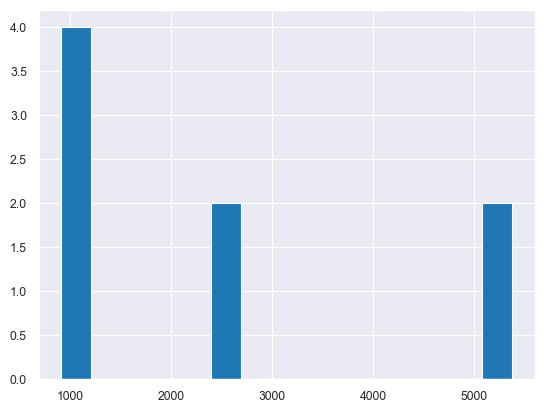

In [30]:
stat_df.groupby(["src", "dest"]).size().sort_values(ascending=False).hist(bins=15)

In [31]:
tgt = stat_df.groupby(["src", "dest"]).size().sort_values(ascending=False).index

In [32]:
src, dest = list(zip(*tgt.values))

In [33]:
heatmap = pd.DataFrame(index=list(set(src)), columns=list(set(dest)))

In [34]:
for (s, d), x in  stat_df.groupby(["src", "dest"]).size().sort_values(ascending=False, ).items():
    heatmap.loc[s,d] = x

<AxesSubplot: >

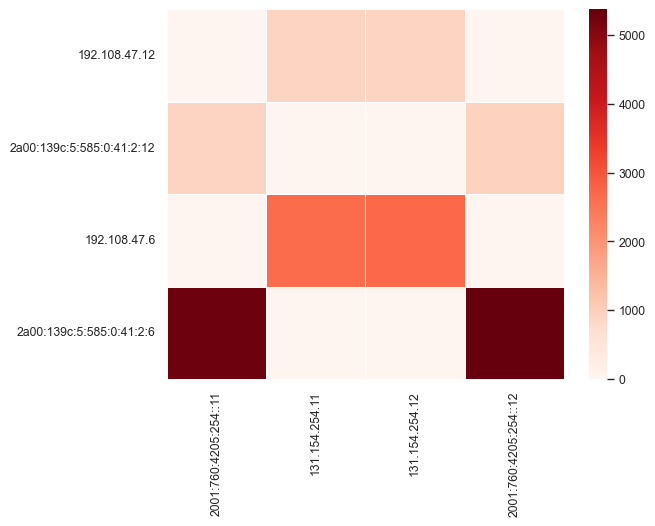

In [37]:
sns.heatmap(heatmap.fillna(0), cmap="Reds", linewidths=0.5, annot=False, )

In [38]:
stat_df.groupby(["src", "dest"]).size().sort_values(ascending=False).head(10)

src                        dest                 
2a00:139c:5:585:0:41:2:6   2001:760:4205:254::12    5373
                           2001:760:4205:254::11    5293
192.108.47.6               131.154.254.12           2693
                           131.154.254.11           2645
2a00:139c:5:585:0:41:2:12  2001:760:4205:254::12     925
                           2001:760:4205:254::11     921
192.108.47.12              131.154.254.12            919
                           131.154.254.11            912
dtype: int64

# Explore the links

In [94]:
tmp = stat_df[(stat_df["src"] == "192.108.47.6" ) & (stat_df["dest"] == "131.154.254.12")]
# 2001:760:4205:254::12

In [95]:
alarms = pd.read_json("data/alarms.json")

In [96]:
alarms.index[0]

0

In [97]:
# alarms["source"].iloc[0]

In [98]:
alarms["created_at"] = pd.to_datetime(alarms["created_at"])

In [99]:
alarms.set_index("created_at", inplace=True)

In [100]:
idx = alarms["source"].apply(lambda x: "INFN-T1" in x and "FZK-LCG2" in x)#.index

In [101]:
# convert timestamps to pd.DatetimeIndex
tmp.index = pd.DatetimeIndex(tmp.index)

<Figure size 640x480 with 0 Axes>

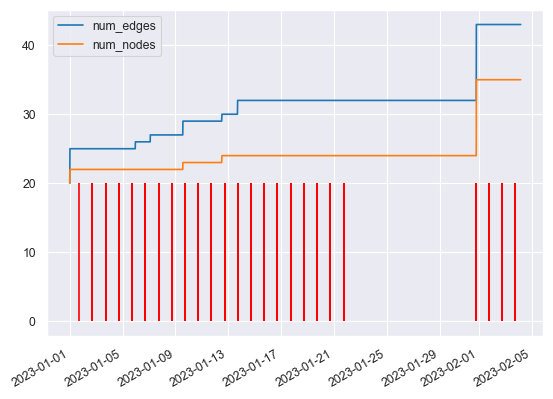

In [102]:
fig=plt.figure()
tmp[["num_edges", "num_nodes"]].plot()
plt.vlines(alarms.loc[(alarms.index > tmp.index.min() ) & (alarms.index < tmp.index.max())].index.intersection(idx.index), 0, 20, color="red")

In [115]:
tmp.select_dtypes(exclude=['object', bool]).resample('15min').mean().plot(backend='plotly')

In [62]:
# tmp["max_delta_rtts"], tmp["max_delta_ttls"]= tmp["max_delta_ttls"], tmp["max_delta_rtts"], 

In [116]:
fig=plt.figure()
tmp.drop(columns=["num_edges", "num_nodes"]).corr()
# plt.vlines(alarms.loc[(alarms.index > tmp.index.min() ) & (alarms.index < tmp.index.max())].index, 2, 10, color="red")


/tmp/ipykernel_46227/2303209354.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,max_delta_rtts,max_delta_ttls,n_hops,reached
max_delta_rtts,1.000000,-0.012924,0.024115,0.024435
max_delta_ttls,-0.012924,1.000000,0.033037,0.027444
n_hops,0.024115,0.033037,1.000000,0.933926
reached,0.024435,0.027444,0.933926,1.000000


<Figure size 640x480 with 0 Axes>

<AxesSubplot: >

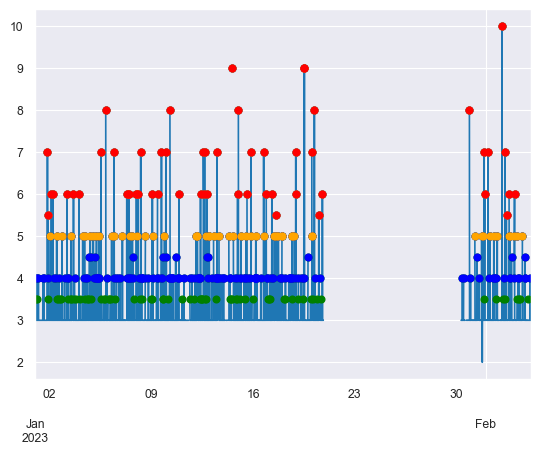

In [126]:
mean_ttls = tmp["max_delta_ttls"].mean()
std_ttls = tmp["max_delta_ttls"].std()
tmp["max_delta_ttls"].plot()
tmp[tmp["max_delta_ttls"]>mean_ttls]["max_delta_ttls"].plot(kind='line', marker='o', linestyle='None', color='green')
tmp[tmp["max_delta_ttls"]>mean_ttls+ std_ttls]["max_delta_ttls"].plot(kind='line', marker='o', linestyle='None', color='blue')
tmp[tmp["max_delta_ttls"]>mean_ttls + 2*std_ttls]["max_delta_ttls"].plot(kind='line', marker='o', linestyle='None', color='orange')
tmp[tmp["max_delta_ttls"]>mean_ttls + 3*std_ttls]["max_delta_ttls"].plot(kind='line', marker='o', linestyle='None', color='red')

In [124]:
tmp = tmp.resample('15min').mean()

/tmp/ipykernel_46227/1388553707.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



<AxesSubplot: >

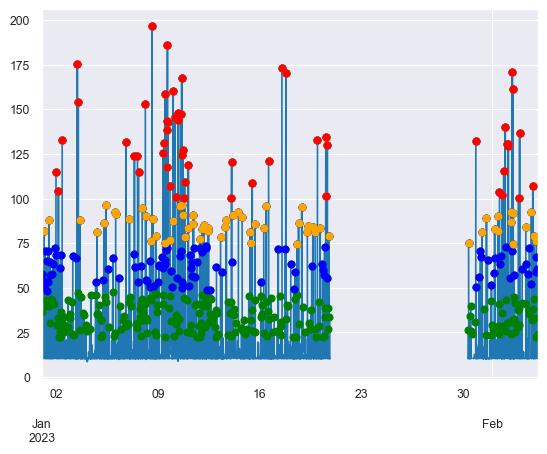

In [127]:
mean_rtts = tmp["max_delta_rtts"].mean()
std_rtts = tmp["max_delta_rtts"].std()

tmp["max_delta_rtts"].plot()
tmp[tmp["max_delta_rtts"]>mean_rtts]["max_delta_rtts"].plot(kind='line', marker='o', linestyle='None', color='green')
tmp[tmp["max_delta_rtts"]>mean_rtts + std_rtts]["max_delta_rtts"].plot(kind='line', marker='o', linestyle='None', color='blue')
tmp[tmp["max_delta_rtts"]>mean_rtts + 2*std_rtts]["max_delta_rtts"].plot(kind='line', marker='o', linestyle='None', color='orange')
tmp[tmp["max_delta_rtts"]>mean_rtts + 3*std_rtts]["max_delta_rtts"].plot(kind='line', marker='o', linestyle='None', color='red')

<AxesSubplot: >

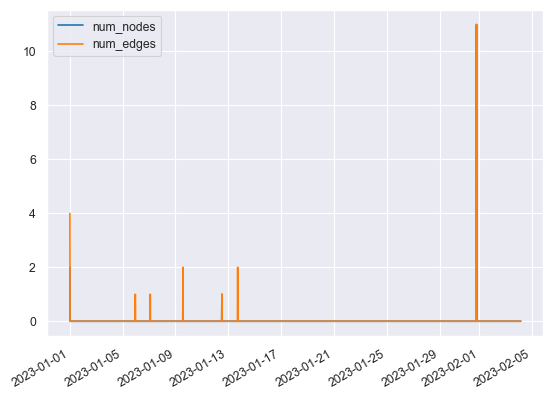

In [120]:
tmp[["num_nodes", "num_edges"]].diff().plot()

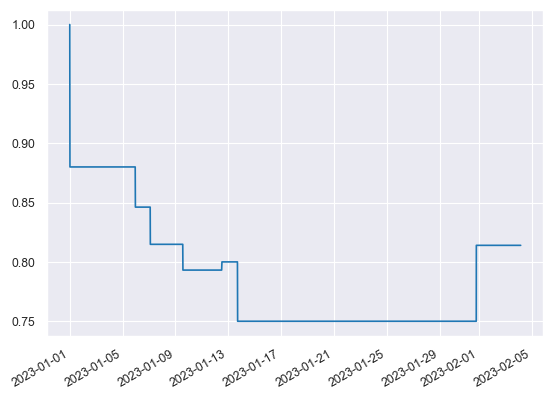

In [121]:
fig=plt.figure()
(tmp["num_nodes"]/tmp[ "num_edges"]).plot()
# plt.vlines(alarms.loc[(alarms.index > tmp.index.min() ) & (alarms.index < tmp.index.max())].index, -0.0075, 0.0041, color="red")
plt.show()